In [526]:
# Imports
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.initializers import GlorotUniform, RandomNormal
print ("TensorFlow version: " + tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import glob
import os
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler

TensorFlow version: 2.17.0


Load Dataset
 Each File has 31 rows and 4 columns. The first 3 columns indicate heart rate, respiratory rate, and oxygen saturation of a baby; the last column indicates if the baby is in pain or not (0 means no pain, 1 means slight pain, 2 means severe pain, # means label is missing).


In [527]:
data_dir = "./Data/"
csv_files = glob.glob(data_dir + "/**/*.csv", recursive=True) # get all csv files in the data directory
combined_csv = pd.concat([pd.read_csv(f, header=None) for f in csv_files], ignore_index=True) # combine all csv files into one dataframe
combined_csv.drop(columns=[0], inplace=True) # drop the first column (index)
combined_csv = combined_csv[combined_csv.iloc[:, 3] != "#"] # remove rows with "#" in the 4th column
combined_csv = combined_csv[combined_csv.iloc[:, 2] != "--1"] # remove row with "--1" in the 3rd column
combined_csv # display the combined dataframe


,1,2,3,4
0,142,60,100,0
1,142,60,100,0
2,142,60,100,0
3,142,59,100,0
4,143,59,100,0
...,...,...,...,...
18657,169,19,98,1
18658,164,50,98,1
18659,164,74,98,1
18660,162,39,99,1


In [528]:
#  Shuffle dataset
from sklearn.utils import shuffle
combined_csv = shuffle(combined_csv)

In [529]:
# Split Dataset
from sklearn.model_selection import train_test_split

train, test = train_test_split(combined_csv, test_size=0.1) 
train, valid = train_test_split(combined_csv, test_size=0.1) # split the dataset into 90% training and 10% validation (test) sets

In [530]:
# Normalized Dataset
scaler = StandardScaler() # initialize scaler
train_x = scaler.fit_transform(train.iloc[:, 0:3]) # fit the scaler on the training data and transform the training data
train_y = train.iloc[:, 3] # get the labels for the training data
valid_x = scaler.transform(valid.iloc[:, 0:3]) # transform the validation data
valid_y = valid.iloc[:, 3] # get the labels for the validation data
test_x = scaler.transform(test.iloc[:, 0:3]) # transform the test data
test_y = test.iloc[:, 3] # get the labels

#  Non-Normalized Dataset
# train_x = train.iloc[:, 0:3].values
# train_y = train.iloc[:, 3].values   
# valid_x = valid.iloc[:, 0:3].values
# valid_y = valid.iloc[:, 3].values
# test_x = test.iloc[:, 0:3].values
# test_y = test.iloc[:, 3].values

In [531]:
# Convert to float32
train_x = np.array(train_x, np.float32)
train_y = np.array(train_y, np.float32)
valid_x = np.array(valid_x, np.float32)
valid_y = np.array(valid_y, np.float32)
test_x = np.array(test_x, np.float32)
test_y = np.array(test_y, np.float32)


# print(train_y.value_counts())

In [532]:
# Models

# Xavier w/ regularizer
# model = Sequential([
#     Input(shape=(3,)),
#     Dense(32, activation='relu', kernel_initializer=GlorotUniform(), kernel_regularizer=regularizers.l2(0.01)),
#     Dense(64, activation='relu', kernel_initializer=GlorotUniform(), kernel_regularizer=regularizers.l2(0.01)),
#     Dense(32, activation='relu', kernel_initializer=GlorotUniform(), kernel_regularizer=regularizers.l2(0.01)),
#     Dense(16, activation='relu', kernel_initializer=GlorotUniform(), kernel_regularizer=regularizers.l2(0.01)),
#     Dense(3, activation='softmax', kernel_initializer=GlorotUniform(), kernel_regularizer=regularizers.l2(0.01))
# ])

# Xavier w/o regularizer
# model = Sequential([
#     Input(shape=(3,)),
#     Dense(32, activation='relu', kernel_initializer=GlorotUniform()),
#     Dense(64, activation='relu', kernel_initializer=GlorotUniform()),
#     Dropout(0.3),
#     Dense(32, activation='relu', kernel_initializer=GlorotUniform()),
#     Dropout(0.3),
#     Dense(16, activation='relu', kernel_initializer=GlorotUniform()),
#     Dense(3, activation='softmax', kernel_initializer=GlorotUniform())
# ])

# Random Normal w/ regularizer
# model = Sequential([
#     Input(shape=(3,)),
#     Dense(32, activation='relu', kernel_initializer=RandomNormal(), kernel_regularizer=regularizers.l2(0.01)),
#     Dense(64, activation='relu', kernel_initializer=RandomNormal(), kernel_regularizer=regularizers.l2(0.01)),
#     Dense(32, activation='relu', kernel_initializer=RandomNormal(), kernel_regularizer=regularizers.l2(0.01)),
#     Dense(16, activation='relu', kernel_initializer=RandomNormal(), kernel_regularizer=regularizers.l2(0.01)),
#     Dense(3, activation='softmax', kernel_initializer=RandomNormal(), kernel_regularizer=regularizers.l2(0.01))
# ])

# Random Normal w/o regularizer
model = Sequential([
    Input(shape=(3,)),
    Dense(32, activation='relu', kernel_initializer=RandomNormal()),
    Dense(64, activation='relu', kernel_initializer=RandomNormal()),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_initializer=RandomNormal()),
    Dropout(0.3),
    Dense(16, activation='relu', kernel_initializer=RandomNormal()),
    Dense(3, activation='softmax', kernel_initializer=RandomNormal())
])

model.summary()

Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_201 (Dense)               │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_202 (Dense)               │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_203 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_204 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_205 (Dense)               │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,899 (19.14 KB)

 Trainable params: 4,899 (19.14 KB)

 Non-trainable params: 0 (0.00 B)

In [533]:
# Optimizers and Compiling

# ADAM Optimizer w/ Learning Rate of 0.1
# model.compile(optimizer=Adam(learning_rate=.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ADAM Optimizer w/ Learning Rate of 0.001
# model.compile(optimizer=Adam(learning_rate=.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Momentum Optimizer w/ Learning Rate of 0.1
# model.compile(optimizer=SGD(learning_rate=.1, momentum=0.7), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Momentum Optimizer w/ Learning Rate of 0.001
model.compile(optimizer=SGD(learning_rate=.001, momentum=0.7), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [534]:
# Define ReduceLROnPlateau callback,hopes in reducing plateu in loss
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)


In [535]:
# Train Model

# Batch Size of 32, Epochs of 80
history = model.fit(train_x, train_y, epochs=80, batch_size=32, validation_data=(valid_x, valid_y), callbacks=[reduce_lr])

# Batch size of 100, epochs of 80
# history = model.fit(train_x, train_y, epochs=80, batch_size=100, validation_data=(valid_x, valid_y), callbacks=[reduce_lr])

Epoch 1/80
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 774us/step - accuracy: 0.5602 - loss: 1.0567 - val_accuracy: 0.5626 - val_loss: 0.9684 - learning_rate: 0.0010
Epoch 2/80
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - accuracy: 0.5673 - loss: 0.9513 - val_accuracy: 0.5626 - val_loss: 0.9180 - learning_rate: 0.0010
Epoch 3/80
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - accuracy: 0.5571 - loss: 0.9137 - val_accuracy: 0.5626 - val_loss: 0.8952 - learning_rate: 0.0010
Epoch 4/80
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - accuracy: 0.5607 - loss: 0.8922 - val_accuracy: 0.5626 - val_loss: 0.8833 - learning_rate: 0.0010
Epoch 5/80
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.5594 - loss: 0.8803 - val_accuracy: 0.5626 - val_loss: 0.8765 - learning_rate: 0.0010
Epoch 6/80
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - accuracy: 0.5611 - loss: 0.8757 - val_accuracy: 0.5626 - val_loss: 0.8724 - learning_rate: 0.0010
Epoch 7/80
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - accuracy: 0.5583 - l

In [536]:
# Quick Evaluation
test_loss, test_acc = model.evaluate(valid_x, valid_y)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.5674 - loss: 0.8656
Test Loss: 0.8643887042999268, Test Accuracy: 0.5626072287559509


In [537]:
# Test Script to Save and Load Moel for Testing
from tensorflow.keras.models import load_model

model.save('models/neural_network_model.keras') # save model
loaded_model = load_model('models/neural_network_model.keras') # load model

# Evaluate on validation set
test_loss, test_acc = loaded_model.evaluate(valid_x, valid_y)



55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.5674 - loss: 0.8656


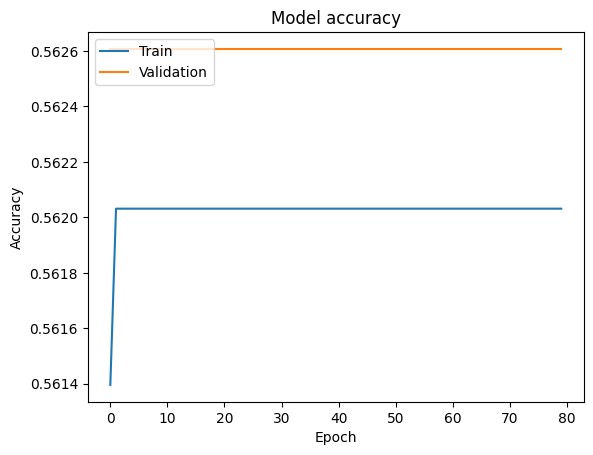

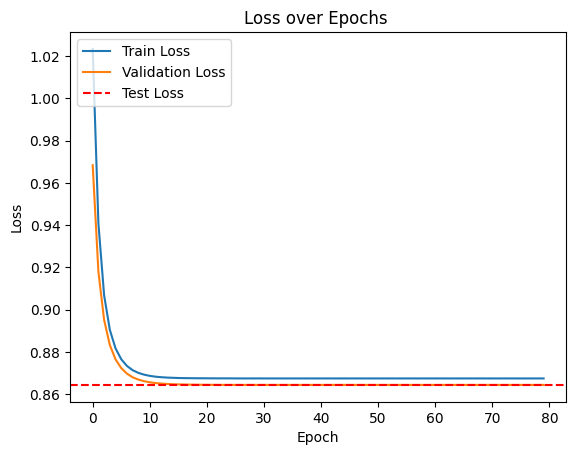

In [538]:
# Visualize Results

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label = "Train Loss")
plt.plot(history.history['val_loss'], label = "Validation Loss")
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss') # plot test loss as horizontal line
plt.title('Loss over Epochs ')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
